In [1]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from util.ImageFolderWithPaths import ImageFolderWithPaths as IFWP

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import numpy as np
import pandas as pd

import sys
import os

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, classification_report
from sklearn.metrics.cluster import adjusted_rand_score

from AutoEncoderCNN import AE, Encoder, Decoder

import pickle
from collections import Counter

In [3]:
enc_out = 8300
encoder = Encoder(out_channel = enc_out)

rand_mat_dim = 4096
decoder = Decoder(out_channel = rand_mat_dim)

In [4]:
models_path='./models/'
rand_mat = torch.load(f'{models_path}rand_mat.pth')
encoder.load_state_dict(torch.load(f'{models_path}encoder.pth'))
decoder.load_state_dict(torch.load(f'{models_path}decoder.pth'))

<All keys matched successfully>

In [5]:
kmeans = pickle.load(open(f"{models_path}kmeans.pickle", 'rb'))
tsne = pickle.load(open(f"{models_path}tsne.pickle", 'rb'))
tsne_results = np.load(f"{models_path}tsne_results.npy")
# df = pd.read_csv("./models/jan_24_25_models/df.csv")

In [6]:
k = kmeans.n_clusters
k

7

In [8]:
df = pd.read_csv(f"{models_path}df.csv")
df = df.drop("Unnamed: 0", axis=1)
arr = np.load(f"{models_path}img_data.npy", allow_pickle=True)
df["Img Data"] = arr
df.head()

X T-SNE    Y T-SNE  True Label  K-means Grouping     Color T     Color K  \
0  -8.927584  26.416164           0                 3    tab:blue     tab:red   
1  10.436820  30.550648           1                 3  tab:orange     tab:red   
2  -3.825497  32.195408           1                 3  tab:orange     tab:red   
3 -20.708185 -35.749430           0                 1    tab:blue  tab:orange   
4   4.394317  24.892082           1                 3  tab:orange     tab:red   

   Patient                                           Img Data  
0       23  [[[0.6666667, 0.73333335, 0.83137256, 0.772549...  
1       81                                               None  
2       90                                               None  
3       40                                               None  
4       79                                               None

In [9]:
temp0 = Counter(df.loc[df["True Label"] == 0]["K-means Grouping"].values)
temp1 = Counter(df.loc[df["True Label"] == 1]["K-means Grouping"].values)

c0 = {}
p0 = {}
for i in range(k):
    c0[i] = temp0[i]
    p0[i] = int( (temp0[i] / sum(temp0.values())*1000)) /1000
c1 = {}
p1 = {}
diff = {}
for i in range(k):
    c1[i] = temp1[i]
    p1[i] = int( (temp1[i] / sum(temp1.values())*1000)) /1000
    diff[i] = int( (p1[i] - p0[i])*1000) /1000


print(f"Asymptomatic:\t{c0} {p0}\nSymptomatic:\t{c1} {p1}\n\nDiff P(S)-P(A):\t{diff}")

Asymptomatic:	{0: 4505, 1: 3802, 2: 8797, 3: 7215, 4: 5209, 5: 2511, 6: 2055} {0: 0.132, 1: 0.111, 2: 0.258, 3: 0.211, 4: 0.152, 5: 0.073, 6: 0.06}
Symptomatic:	{0: 2273, 1: 2676, 2: 5419, 3: 4913, 4: 2095, 5: 1792, 6: 2505} {0: 0.104, 1: 0.123, 2: 0.25, 3: 0.226, 4: 0.096, 5: 0.082, 6: 0.115}

Diff P(S)-P(A):	{0: -0.028, 1: 0.011, 2: -0.008, 3: 0.015, 4: -0.055, 5: 0.009, 6: 0.055}


In [10]:
# create dictionary: d["000"] = {'0': x, '1': ...} 
d = {}
for patient_num, patient_group in df.groupby("Patient"):
    c = Counter(patient_group["K-means Grouping"])
    temp = {}
    for i in range(k):
        try:
            temp[i] = c[i]
        except KeyError:
            temp[i] = 0
    d[patient_num] = temp
d    

{1: {0: 81, 1: 29, 2: 126, 3: 134, 4: 86, 5: 25, 6: 51},
 2: {0: 38, 1: 5, 2: 156, 3: 355, 4: 263, 5: 4, 6: 68},
 4: {0: 261, 1: 8, 2: 153, 3: 128, 4: 208, 5: 19, 6: 26},
 5: {0: 256, 1: 33, 2: 182, 3: 18, 4: 54, 5: 59, 6: 3},
 6: {0: 8, 1: 17, 2: 95, 3: 140, 4: 69, 5: 1, 6: 25},
 7: {0: 20, 1: 0, 2: 22, 3: 95, 4: 50, 5: 0, 6: 49},
 8: {0: 171, 1: 192, 2: 248, 3: 112, 4: 83, 5: 178, 6: 26},
 9: {0: 32, 1: 348, 2: 167, 3: 119, 4: 13, 5: 91, 6: 36},
 10: {0: 158, 1: 18, 2: 65, 3: 46, 4: 22, 5: 93, 6: 17},
 11: {0: 157, 1: 117, 2: 227, 3: 143, 4: 116, 5: 38, 6: 47},
 12: {0: 86, 1: 62, 2: 179, 3: 156, 4: 158, 5: 12, 6: 25},
 13: {0: 25, 1: 297, 2: 92, 3: 23, 4: 1, 5: 127, 6: 0},
 14: {0: 7, 1: 287, 2: 7, 3: 13, 4: 1, 5: 33, 6: 2},
 15: {0: 28, 1: 315, 2: 52, 3: 19, 4: 4, 5: 34, 6: 25},
 16: {0: 59, 1: 331, 2: 112, 3: 41, 4: 14, 5: 190, 6: 16},
 17: {0: 256, 1: 91, 2: 281, 3: 85, 4: 119, 5: 90, 6: 5},
 18: {0: 31, 1: 64, 2: 142, 3: 150, 4: 188, 5: 1, 6: 15},
 19: {0: 259, 1: 9, 2: 287, 3: 

In [11]:
amt_imgs = 10
k_img_arr = []
t_img_arr = []

# Populate img_arr with 3 items, of amt_imgs imgs per item
# Note the index will be the corresponding k
for k_temp, df_group in df.groupby("K-means Grouping"):
    k_img_arr.append([])
    for img in df_group["Img Data"]:
        if img is not None and str(img) != 'nan':
            k_img_arr[k_temp].append(img)


# Populate img_arr with 2 items, of amt_imgs imgs per item
# Note the index will be the corresponding label
for t_temp, df_group in df.groupby("True Label"):
    t_img_arr.append([])
    for img in df_group["Img Data"]:
        if img is not None:
            t_img_arr[t_temp].append(img)

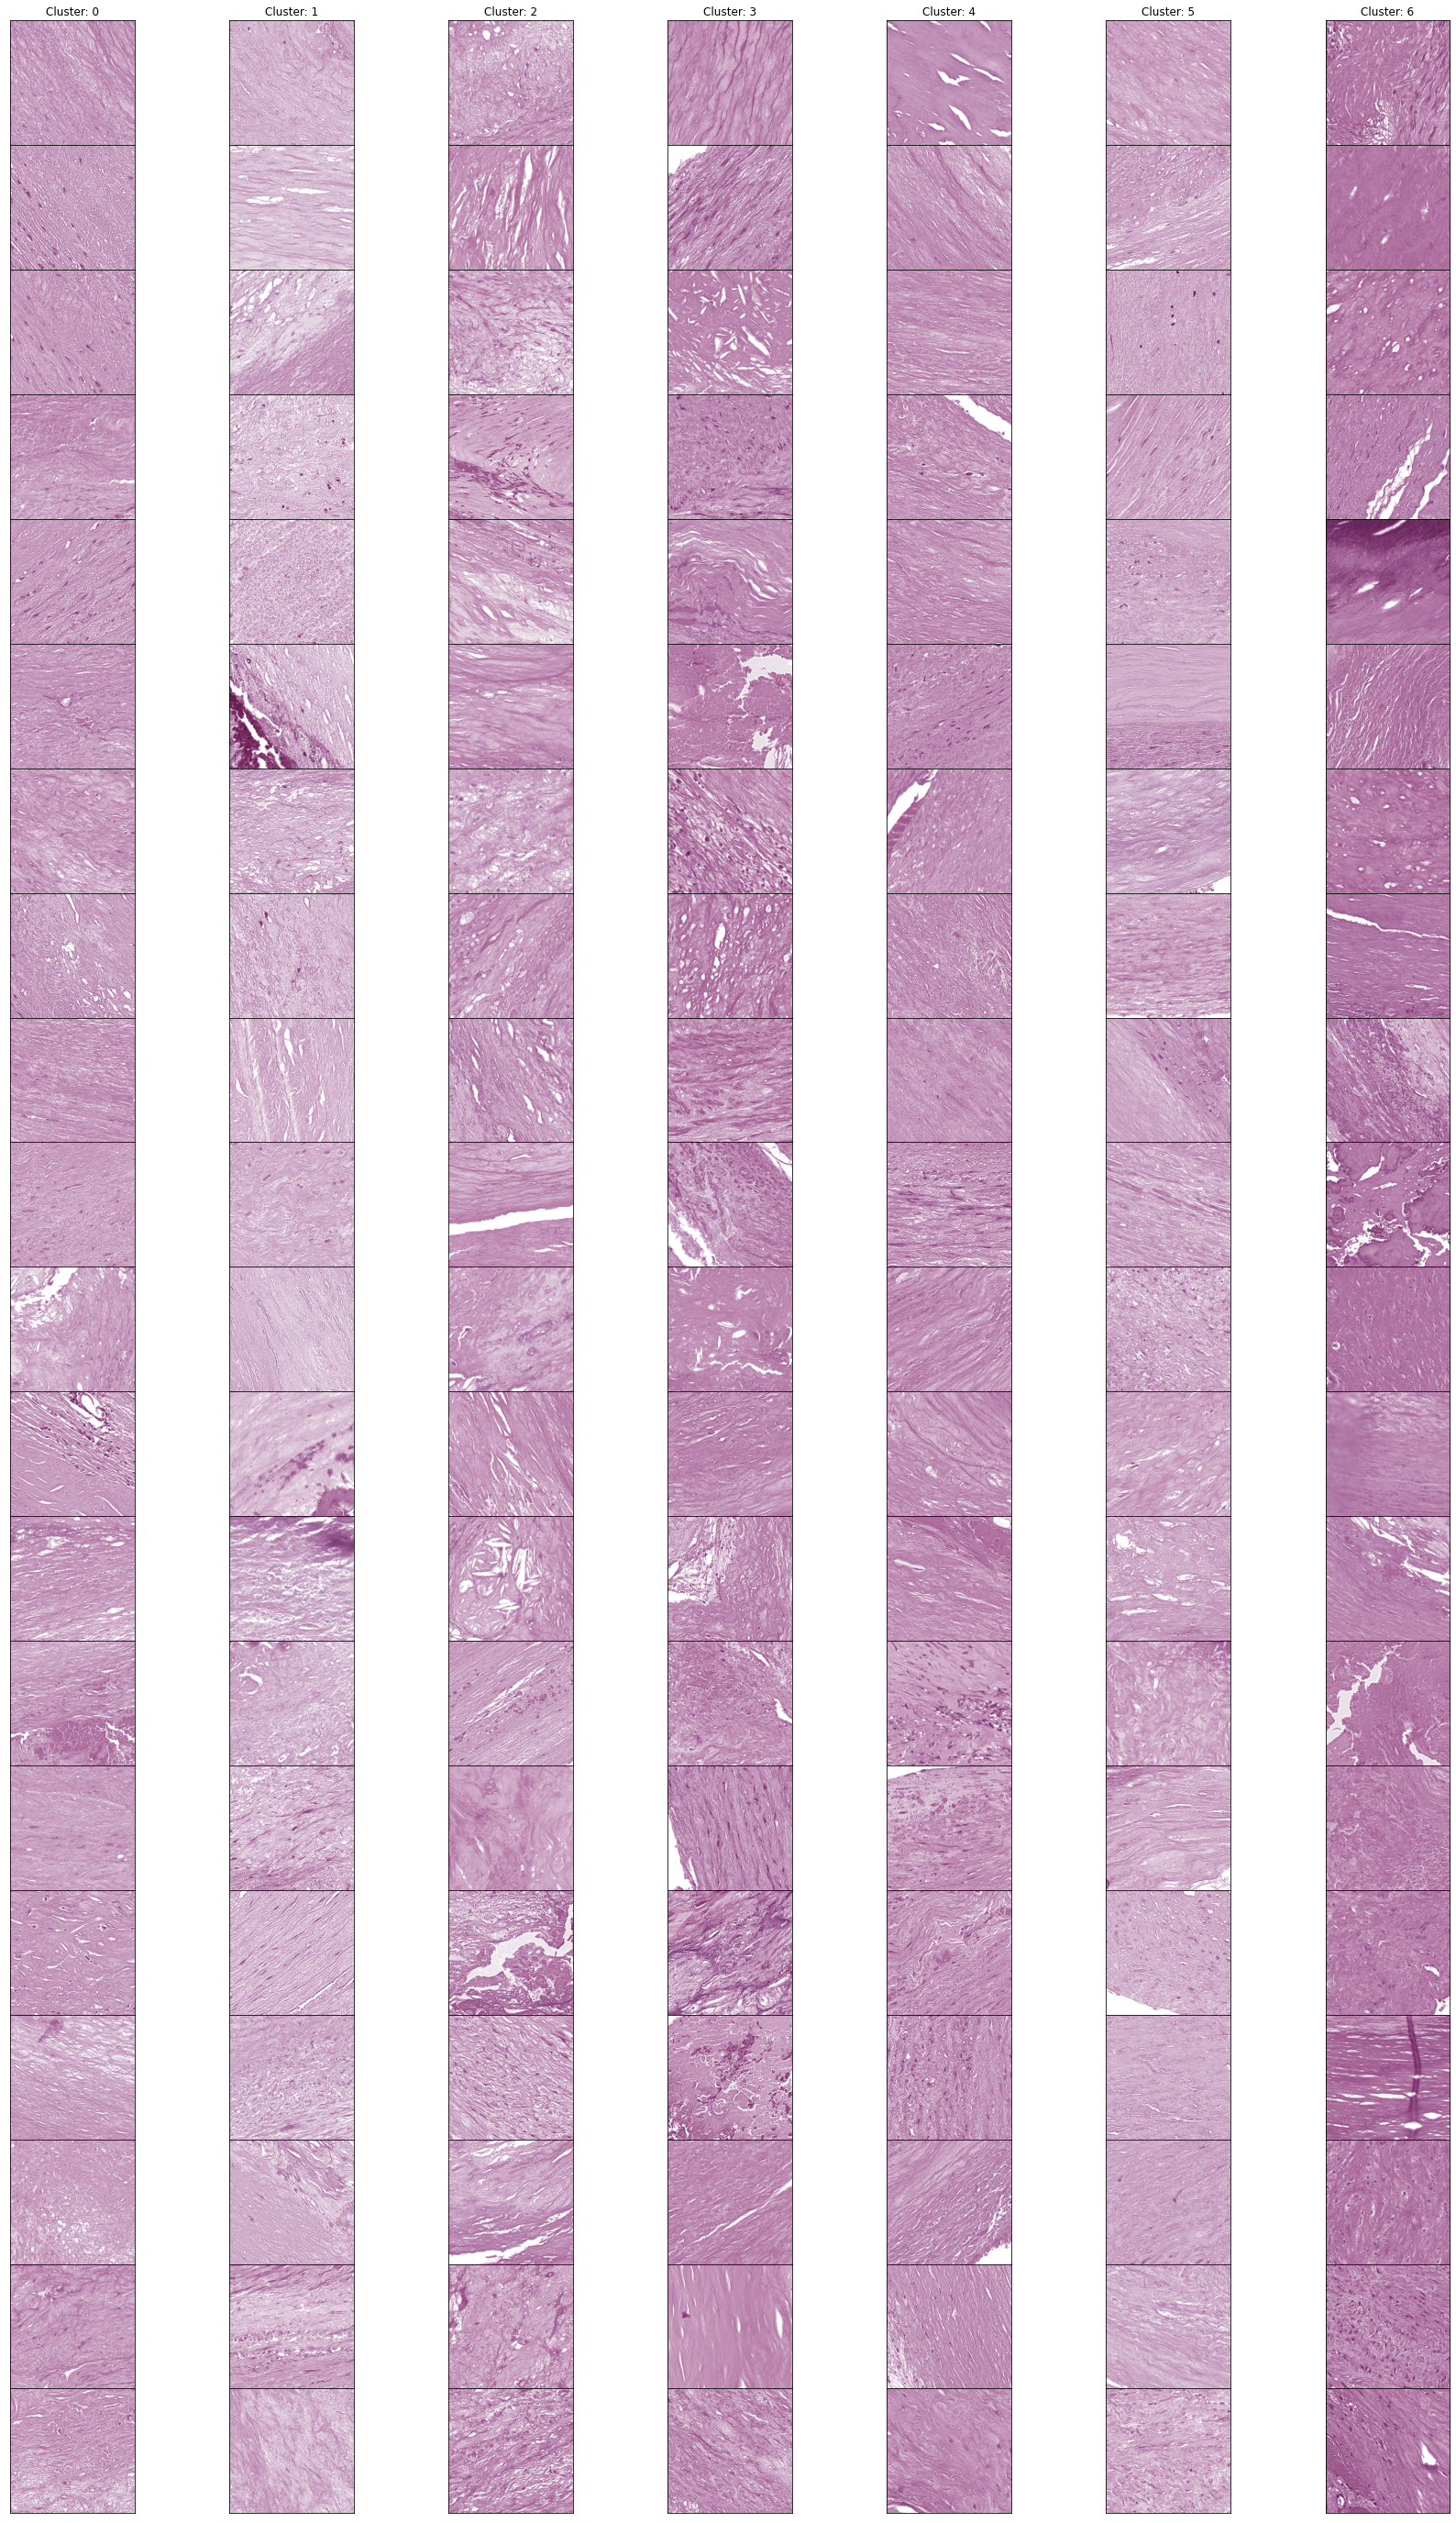

In [27]:
amt_imgs = 20
widths = [0.05] + [(0.075/k) for i in range(k)]
gs = fig.add_gridspec(amt_imgs, k+1, width_ratios=widths, wspace=0, hspace=0)

fig = plt.figure(figsize=(50,50))
# Loop across cols
for j in range(1, k+1):
    # Loop across row
    for i in range(0,amt_imgs):
        # Create new subplot
        ax = fig.add_subplot(gs[i, j])
        if i == 0:
            ax.set_title(f"Cluster: {j-1}")
        
        # Remove axis ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        img = k_img_arr[j-1][i]
        plt.imshow(np.transpose(img, (1,2,0)))
   


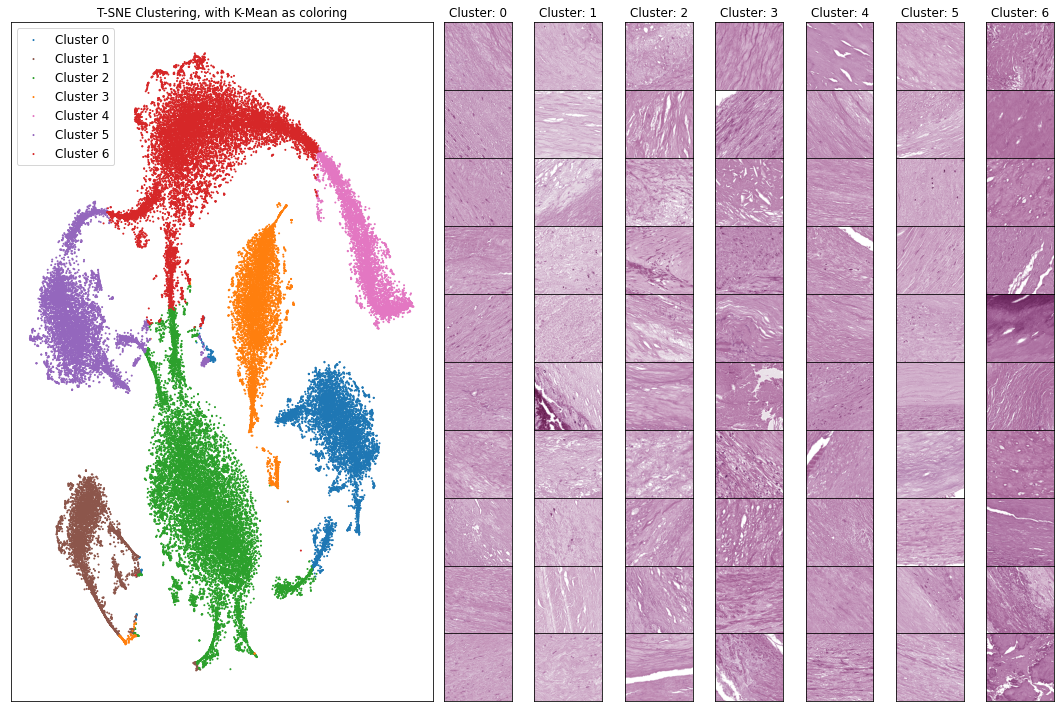

In [15]:
fig = plt.figure(figsize=(15,10))

widths = [0.05] + [(0.075/k) for i in range(k)]
gs = fig.add_gridspec(amt_imgs, k+1, width_ratios=widths, wspace=0, hspace=0)
 
# create sub plots as grid
ax = fig.add_subplot(gs[:, 0])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for color, df_group in df.groupby("Color K"):
    plt.scatter(df_group["X T-SNE"], df_group["Y T-SNE"], c=df_group["Color K"], 
                label=f"Feature {color}", s=1)
ax.set_title("T-SNE Clustering, with K-Mean as coloring")
legend_arr = [f"Cluster {i}" for i in range(k)]
plt.legend(legend_arr, prop={'size': 12})

# Loop across cols
for j in range(1, k+1):
    # Loop across row
    for i in range(0,amt_imgs):
        # Create new subplot
        ax = fig.add_subplot(gs[i, j])
        if i == 0:
            ax.set_title(f"Cluster: {j-1}")
        
        # Remove axis ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        img = k_img_arr[j-1][i]
        plt.imshow(np.transpose(img, (1,2,0)))

# Display the plots
plt.tight_layout()
plt.show()

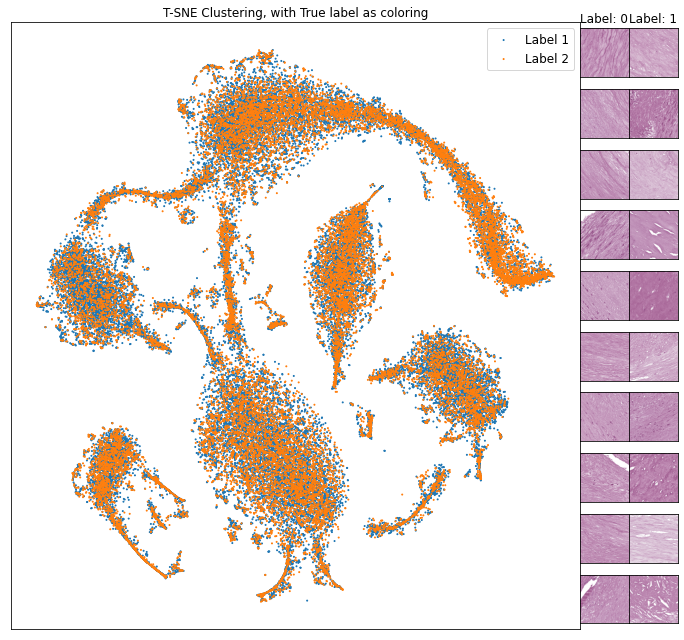

In [14]:
fig = plt.figure(figsize=(13,9))

widths = [0.125] + [(0.075/k) for i in range(k)]
gs = fig.add_gridspec(amt_imgs, k+1, width_ratios=widths, wspace=0, hspace=0)
 
# create sub plots as grid
ax = fig.add_subplot(gs[:, 0])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for color, df_group in df.groupby("Color T"):
    plt.scatter(df_group["X T-SNE"], df_group["Y T-SNE"], c=df_group["Color T"], 
                label=f"Feature {color}", s=1)
    
plt.xticks([])  
plt.yticks([])
plt.title("T-SNE Clustering, with True label as coloring")

legend_arr = [f"Label {i+1}" for i in range(max(df["True Label"]) - min(df["True Label"]) +1)]
plt.legend(legend_arr, prop={'size': 12})

# Loop across cols
for j in range(1, 3):
    # Loop across row
    for i in range(0,amt_imgs):
        # Create new subplot
        ax = fig.add_subplot(gs[i, j])
        if i == 0:
            ax.set_title(f"Label: {j-1}")
        
        # Remove axis ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        img = t_img_arr[j-1][i]
        plt.imshow(np.transpose(img, (1,2,0)))

# Display the plots
plt.tight_layout()
plt.show()